In [1]:
import jax
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from itertools import count
import jax.random as jr
import jax.scipy as jsci
from jax import jit,vmap, lax
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from functools import partial
from utils import *
from plotting_utils import *
from inference_and_sample import *
import task_subspace_LDS



keys = map(jr.PRNGKey, count())

In [2]:
print("jax:", jax.__version__)
print("devices:", jax.devices())
print("default backend:", jax.default_backend())

# !nvidia-smi

jax: 0.5.3
devices: [CudaDevice(id=0)]
default backend: gpu


In [42]:
# hyperparameters
D = 50
K1 = 3
K2 = 2
K = K1+K2
M = 2

S = 200
T = 100

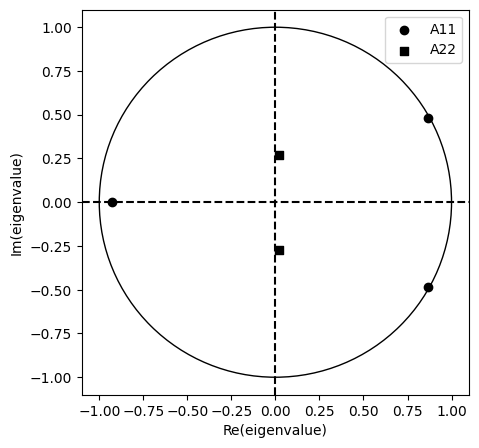

In [4]:
eigs1 = generate_eigenvalues(next(keys), K1, R=0.999, r=0.8)
eigs2 = generate_eigenvalues(next(keys), K2, R=0.3, r=0.1)

fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, eigs1, eigs2, color='black', label=['A11','A22'], alpha=1)
axes.legend()



In [5]:
LDS = task_subspace_LDS.task_subspace_LDS(D, K1, K2, M)
trueA = LDS.generate_dynamics_matrix(next(keys), eigs1, eigs2)
trueu = LDS.generate_inputs(next(keys), S, T)
trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR = LDS.generate_other_parameters(next(keys), trueA)

In [6]:
# checking that trueA has the desired eigenvalues
eigvals1 = jnp.linalg.eigvals(trueA[:K1,:K1])
eigvals2 = jnp.linalg.eigvals(trueA[K1:,K1:])

print(compare_as_sets(eigvals1, eigs1, tol=1e-12))
print(compare_as_sets(eigvals2, eigs2, tol=1e-12))
print(compare_as_sets(jnp.concatenate([eigvals1, eigvals2]), jnp.linalg.eigvals(trueA), tol=1e-12))


True
True
True


In [7]:
# x_single, y_single = generate_latents_and_observations(next(keys), trueu[0], trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [8]:
# whole sessions generation
keys_batch = jr.split(next(keys), S)
truex, truey = generate_latents_and_observations_batches(keys_batch, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [9]:
jnp.savez('model_to_check.npz', truex=truex, truey=truey, trueu=trueu, trueA=trueA, trueB=trueB, trueQ=trueQ, truemu0=truemu0, trueQ0=trueQ0, trueC=trueC, trued=trued, trueR=trueR)

In [10]:
mu, mu_prior, V, V_prior, ll = Kalman_filter_E_step_batches(truey, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)
m, cov, cov_successive = Kalman_smoother_E_step_batches(trueA, mu, mu_prior, V, V_prior)

In [11]:
# Per-session stats (each with leading S axis)
sufficient_stats = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

# Sum across sessions for every leaf
stats = tree_map(lambda x: x.sum(axis=0), sufficient_stats)
M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = stats

print(M_first.shape)

(5, 5)


In [53]:
# A, B, Q, mu0, Q0, C, d, R, timing_log = LDS.fit_EM_timed(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR,max_iter=5, verbosity=0, print_every=1)
# print(timing_log[-1])

# # fit staring from true parameters
# A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll = LDS.fit_EM(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR, max_iter=300)

# fit starting from random init
initeigs1 = generate_eigenvalues(next(keys), K1, R=0.999, r=0.8)
initeigs2 = generate_eigenvalues(next(keys), K2, R=0.3, r=0.1)
initA = LDS.generate_dynamics_matrix(next(keys), initeigs1, initeigs2)
initB, initQ, initmu0, initQ0, initC, initd, initR = LDS.generate_other_parameters(next(keys), initA)
A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll = LDS.fit_EM(K1, trueu, truey, initA, initB, initQ, initmu0, initQ0, initC, initd, initR, max_iter=200)

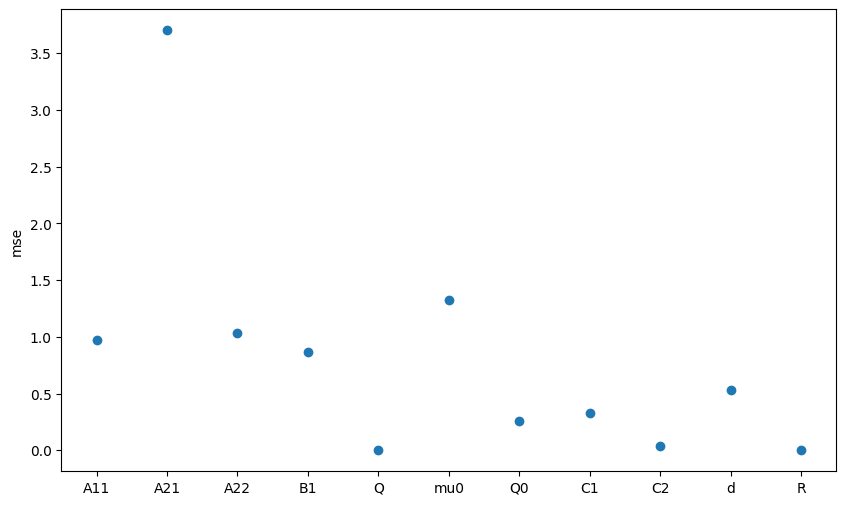

In [56]:
fig, axes = plt.subplots(figsize=(10,6))
plot_mse_parameters(axes, K1, A, B, trueQ, mu0, Q0, C, d, R, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

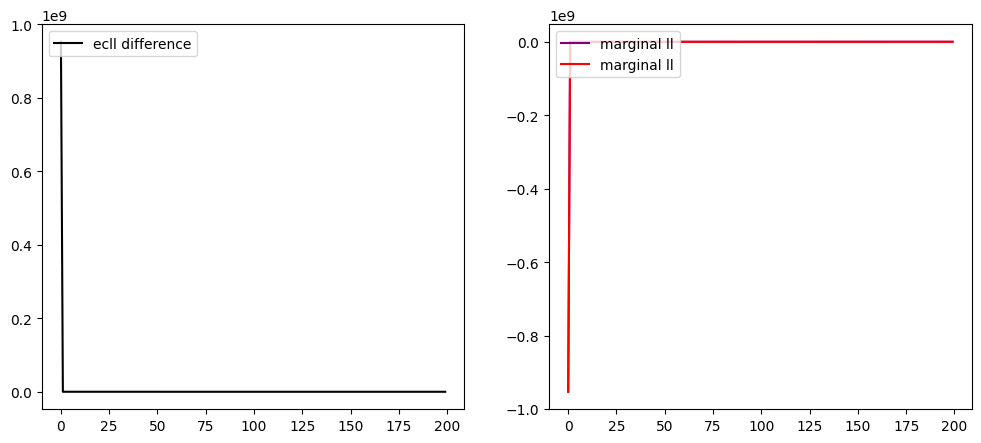

In [55]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll difference')
axes[1].plot(elbo, color='purple', label='marginal ll')
axes[1].plot(ll, color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

(50, 50)


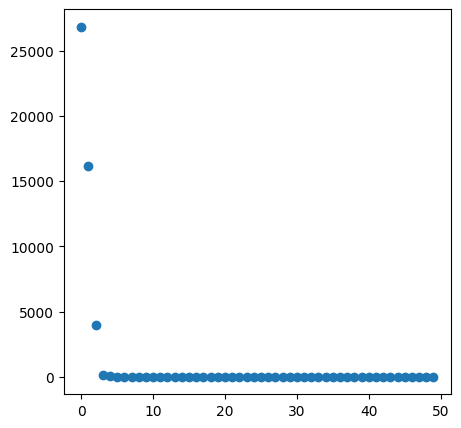

In [36]:
# checking that doing PCA on data gives back true C or orthogonalization of C
print((truey[0].T @ truey[0]).shape)

truey_pca = truey.mean(axis=0)

# SVD on Y^T Y is the same as PCA on Y
U, S, VT = jnp.linalg.svd(truey_pca.T @ truey_pca)  # U[:,:K] has K column vectors defining PCA space

# look at variance captured
fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(range(S.shape[0]), S)


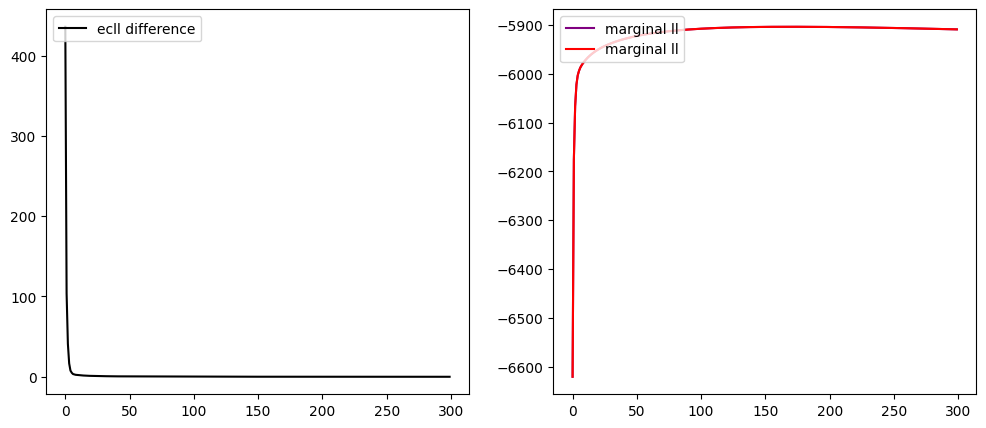

In [51]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll difference')
axes[1].plot(elbo, color='purple', label='marginal ll')
axes[1].plot(ll, color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

In [43]:
# checking alignment of C and PCA space
print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC) / jnp.linalg.norm(trueC))
print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC - trueC))



0.8983671068436535
0.9821826239079826


In [45]:
Uc, Sc, VTc = jnp.linalg.svd(trueC, full_matrices=False)
print(Uc.shape)
print(jnp.linalg.norm(U[:,:K] - Uc))


(50, 5)
3.461953038092131


In [14]:
print(mse(R,trueR))

6.841956884751949e-07


In [15]:
print(mse(C[:,:K1],trueC[:,:K1]))
print(mse(C[:,K1:],trueC[:,K1:]))
# mu0 has larger error, but still under 0.2
# d has very large error


4.1805132565062045e-06
2.2161201315601405e-06


In [16]:
print(cov_successive.shape)

(200, 99, 5, 5)


-1977063.9066138251
-806.304519230697
